author: spe

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It reproduces Figs. 3-5 of Devlin, J. A. and
Tarbutt, M. R. (2016) ‘Three-dimensional Doppler, polarization-gradient, and
magneto-optical forces for atoms and molecules with dark states’, New Journal of
Physics, 18(12), p. 123017. doi: 10.1088/1367-2630/18/12/123017.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.tools
import copy
import time
import cProfile, pstats, io
#plt.style.use('paper')

Figure 4:

In [3]:
det = -2.5
beta = 2.0

laserBeams = {}

laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.tools.standard_six_beam_MOT(beta, det)
laserBeams['lin$\perp$lin'] = []
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([0., 0., 1.]), pol=np.array([1., 0., 0.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([0., 0., -1.]), pol=np.array([0., 1., 0.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([0., 1., 0.]), pol=np.array([0., 0., 1.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([0., -1., 0.]), pol=np.array([1., 0., 0.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([1., 0., 0.]), pol=np.array([0., 1., 0.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)
laserBeams['lin$\perp$lin'].append(
    pylcp.laserBeam(np.array([-1., 0., 0.]), pol=np.array([0., 0., 1.]),
                    beta=beta, delta=det, pol_coord='cartesian')
)

hamiltonian = {}
for Fg, Fe in zip([1, 1, 1, 2], [2, 1, 0, 1]):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fg, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fe, gF=0, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fg, Fe)
    hamiltonian['Fg%d;Fe%d'%(Fg,Fe)] = pylcp.hamiltonian(Hg, He, Bgq,
                                                          Beq, dijq)

magField = lambda R: np.zeros(R.shape)


Figure 4:

In [4]:
ham_key='Fg1;Fe2'
laser_key='$\\sigma^+\\sigma^-$'
Nrandom = 32

"""vmags = np.concatenate((np.arange(0.001, 0.01, 0.001),
                        np.arange(0.01, 0.1, 0.005),
                        np.arange(0.1, 1.0, 0.05)))"""
vmags = np.arange(0.001, 0.102, 0.25)

obe={}
F_avg={}

tic=time.time()
for ham_key in hamiltonian.keys():
    if not ham_key in obe.keys():
        obe[ham_key] = {}
        F_avg[ham_key] = {}

    for laser_key in laserBeams.keys():
        print('Working on %s w/ %s:' % (ham_key, laser_key))
        F_avg[ham_key][laser_key] = np.zeros(vmags.shape)

        for ii, vmag in enumerate(vmags):
            rs = np.random.random(size=(3, Nrandom))*2*np.pi
            phi = np.random.random(size=(Nrandom,))*2*np.pi
            theta = np.arccos(2*np.random.random(size=(Nrandom,))-1)

            vs = np.array([vmag*np.sin(theta)*np.cos(phi),
                           vmag*np.sin(theta)*np.sin(phi),
                           vmag*np.cos(theta)])

            obe[ham_key][laser_key] = pylcp.obe(
                laserBeams[laser_key], magField, hamiltonian[ham_key],
                transform_into_re_im=True
            )

            obe[ham_key][laser_key].generate_force_profile(
                rs, vs, name='molasses_3D_v%.2f'%vmag, deltat_v=8,
                deltat_tmax=2*np.pi*1000, itermax=10,
                rel=1e-8, abs=1e-10, progress_bar=True, use_jit=True
            )

            F_avg[ham_key][laser_key][ii] = np.mean(np.sum(
                obe[ham_key][laser_key].profile['molasses_3D_v%.2f'%vmag].F*
                vs/vmag,
                axis=0))

toc=time.time()
print('Total computation time is %.2f s.' % (toc-tic))


Working on Fg1;Fe2 w/ $\sigma^+\sigma^-$:


C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `use_jit`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))
C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `use_jit`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))
C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `use_jit`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


AttributeError: 'NoneType' object has no attribute 'rho'

KeyError: 'lin$\\perp$lin'

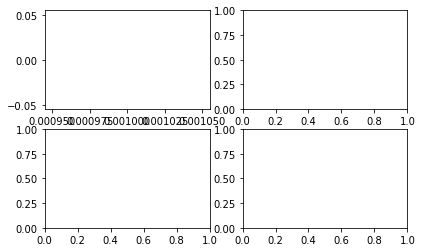

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(6.5, 4.0))
for ii, ham_key in enumerate(hamiltonian.keys()):
    for laser_key in laserBeams.keys():
        ax[int(ii/2), ii%2].plot(vmags, F_avg[ham_key][laser_key], linewidth=0.75)

ax[1, 0].set_xlabel('$v/(\Gamma/k)$')
ax[1, 1].set_xlabel('$v/(\Gamma/k)$')
ax[0, 1].set_ylabel('$F/(\hbar k \Gamma)$')
ax[0, 1].set_ylabel('$F/(\hbar k \Gamma)$')

fig.savefig("03_F_to_Fp_3D_molasses.pdf")
